In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from ISLP import load_data
from scipy.stats import \
    (ttest_1samp,
     ttest_rel,
     ttest_ind,
     t as t_dbn)
from statsmodels.stats.multicomp import \
     pairwise_tukeyhsd
from statsmodels.stats.multitest import \
     multipletests as mult_test

# Review of Hypothesis Testing

Creating the data

In [6]:
rng = np.random.default_rng(12)
X = rng.standard_normal((10, 100)) # n = 10, p = 100; mean = 0, variance = 1
true_mean = np.array([0.5]*50 + [0]*50) # offsetting half the data to mean 0.5
X += true_mean[None,:]

Using `scipy.stats.ttest_1samp()` to test H0 (that the mean is 0) on the first variable (which comes out wrongly)

In [ ]:
result = ttest_1samp(X[:,0], 0)
print(result.pvalue)
# p-value is .93, so we don't reject, which is wrong (mean is 0.5)

0.9307442156164141


Doing this for all 100 predictors, then creates an array with values being either "Reject H0" or "Do not reject H0" (Prediction) using `pd.cut()`. Then similarly creates an array with values being "True" or "False" (Truth) using `pd.Categorical()`. Then visualize using `pd.crosstab()`.

Then we can see that the p-value being 0.05 holds (5 out of 100 variables are Type I errors).

In [10]:
p_values = np.empty(100)
for i in range(100):
   p_values[i] = ttest_1samp(X[:,i], 0).pvalue

decision = pd.cut(p_values,
                  [0, 0.05, 1], # under 0.05 (inclusive) is rejected
                  labels=['Reject H0',
                          'Do not reject H0'])
truth = pd.Categorical(true_mean == 0,
                       categories=[True, False], # unique categories
                       ordered=True)
pd.crosstab(decision,
            truth,
            rownames=['Decision'],
            colnames=['H0'])

H0,True,False
Decision,,
Reject H0,5,15
Do not reject H0,45,35


Doing the same, but with stronger data: Setting the mean of one half to 1, the other to 0. This results in a lower Type I error.

In [11]:
true_mean = np.array([1]*50 + [0]*50)
X = rng.standard_normal((10, 100))
X += true_mean[None,:]
for i in range(100):
   p_values[i] = ttest_1samp(X[:,i], 0).pvalue
decision = pd.cut(p_values,
                  [0, 0.05, 1],
                  labels=['Reject H0',
                          'Do not reject H0'])
truth = pd.Categorical(true_mean == 0,
                       categories=[True, False],
                       ordered=True)
pd.crosstab(decision,
            truth,
            rownames=['Decision'],
            colnames=['H0'])

H0,True,False
Decision,,
Reject H0,2,40
Do not reject H0,48,10


# Family-Wise Error Rate (FWER)

Plotting the FWER for different alpha

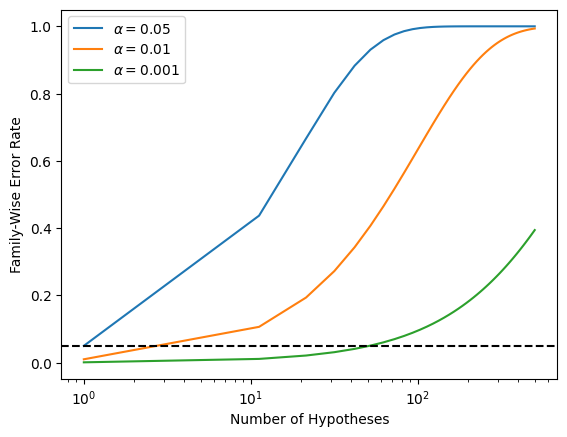

In [12]:
m = np.linspace(1, 501)
fig, ax = plt.subplots()
[ax.plot(m,
         1 - (1 - alpha)**m,
         label=r'$\alpha=%s$' % str(alpha))
         for alpha in [0.05, 0.01, 0.001]]
ax.set_xscale('log')
ax.set_xlabel('Number of Hypotheses')
ax.set_ylabel('Family-Wise Error Rate')
ax.legend()
ax.axhline(0.05, c='k', ls='--')

Result: for testing 50 variables, the FWER exceeds 0.05 even at alpha 0.001.

Getting new Data: Fund dataset.

In [13]:
Fund = load_data('Fund')
fund_mini = Fund.iloc[:,:5]

Conducting a one-sample t-test for each of the first five managers (predictors) for H0 = the mean to be 0:

In [14]:
fund_mini_pvals = np.empty(5)
for i in range(5):
    fund_mini_pvals[i] = ttest_1samp(fund_mini.iloc[:,i], 0).pvalue
print(fund_mini_pvals)

[0.00620236 0.91827115 0.01160098 0.6005396  0.75578151]


This gives sufficiently low p-values for the first and third managers. So now we use Bonferroni's Correction using `statsmodels.stats.multitest.multipletests()` as mult_test. It returns the decisions (reject) and the adjusted values (bonf) in arrays.

In [15]:
reject, bonf = mult_test(fund_mini_pvals, # p-values
                         method = "bonferroni")[:2]
print(reject)

[ True False False False False]


So now we only reject the first manager's H0.

Doing the same using Holm's method, the first and third H0 are rejected.

In [16]:
reject_holm, holm = mult_test(fund_mini_pvals, method = "holm", alpha=0.05)[:2]
print(reject_holm)

[ True False  True False False]


When checking significance of a difference in between different predictors, you can use `scipy.stats.ttest_rel()` and get its p-value.

In [17]:
ttest_rel(fund_mini['Manager1'],
          fund_mini['Manager2']).pvalue

0.038391072368079586

# False Dicovery Rate (FDR)

First we perform Hypothesis tests for all 2000 managers.

Then we use the Benjamini-Hochberg method using ``statsmodels.stats.multitest.multipletests()`` again.

Then we see for how many managers we can reject H0 if the FDR should not exceed 10%.

In [18]:
fund_pvalues = np.empty(2000)
for i, manager in enumerate(Fund.columns):
    fund_pvalues[i] = ttest_1samp(Fund[manager], 0).pvalue

fund_qvalues = mult_test(fund_pvalues, method = "fdr_bh")[1]
print(fund_qvalues[:10])

print((fund_qvalues <= 0.1).sum())

[0.08988921 0.991491   0.12211561 0.92342997 0.95603587 0.07513802
 0.0767015  0.07513802 0.07513802 0.07513802]
146


146 are significant, and maximum 10% of those should be false discoveries.

Now we visualize the data.

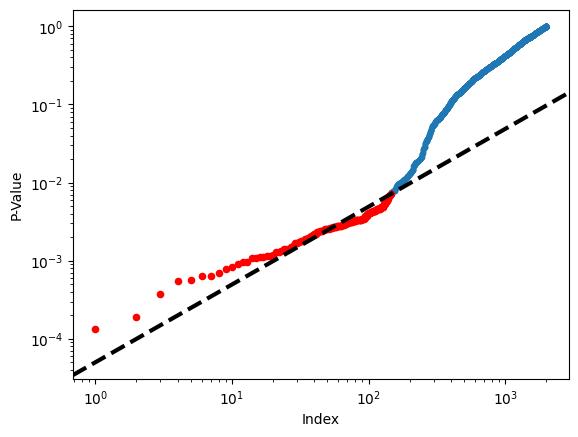

In [20]:
# implementing the method ourselves in order to generate the necessary data
sorted_ = np.sort(fund_pvalues)
m = fund_pvalues.shape[0]
q = 0.1
sorted_set_ = np.where(sorted_ < q * np.linspace(1, m, m) / m)[0]
if sorted_set_.shape[0] > 0:
    selected_ = fund_pvalues < sorted_[sorted_set_].max()
    sorted_set_ = np.arange(sorted_set_.max())
else:
    selected_ = []
    sorted_set_ = []

# visualizing
fig, ax = plt.subplots()
ax.scatter(np.arange(0, sorted_.shape[0]) + 1,
           sorted_, s=10)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylabel('P-Value')
ax.set_xlabel('Index')
ax.scatter(sorted_set_+1, sorted_[sorted_set_], c='r', s=20)
ax.axline((0, 0), (1,q/m), c='k', ls='--', linewidth=3)